# Brain Tumor Classification
## Objective:
The goal of this notebook is to classify MRI images of brain tumors into multiple categories using Machine Learning and Deep Learning models, and tracking all differents models with differents hyperparameters with Mlflow.
## Dataset:
- Source: [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
- The dataset includes MRI images divided into different tumor types and "No Tumor" as a class.
- It contains 7023 instances for 4 targets :
1. **Gliome**  
2. **Méningiome**  
3. **Aucune Tumeur**  
4. **Hypophyse**  
> DataSet process and models comparison are in the other notebook.
This notebook includes:
- Experiment Tracking with MLflow: Utilize MLflow for logging experiments, managing model versions, and tracking performance, and monitoring hyperparameters
- Model explainability and interpretability.
- FastAPI developped with FLASK.

> We've tried three models, the best of which is Random Forest in terms of performance and execution time.
>
> As a result, interpretability with LIME and fastAPI have only been developed on the best RandomForest model given by GrdiSearch.

##### Realized by :  
- Zakaria KOUHIL
- Yasmine ZEMMOURI
- Yasmine MESDOUR
- Ilyas GHAZOUI

# Step 1: Import necessary libraries

In [17]:
import pandas as pd
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, AUC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, classification_report, roc_auc_score, recall_score, precision_score, RocCurveDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from skimage import io, color, transform
import mlflow.keras
import mlflow
import mlflow as mlf
import mlflow.sklearn as mlfsk
from scikeras.wrappers import KerasClassifier

# Affichage en ligne des graphiques
%matplotlib inline


> Explanation
This block imports essential libraries for data processing, machine learning, deep learning, visualization, and experiment tracking. It prepares the environment for building and training models.


# Step 2: Set Up MLflow and Required Libraries


In [ ]:
mlf.set_tracking_uri("http://127.0.0.1:5000")

# Set up a new experiment
mlf.set_experiment("Brain_Tumor_Classification")


<Experiment: artifact_location='mlflow-artifacts:/286751057660019599', creation_time=1733869508157, experiment_id='286751057660019599', last_update_time=1733869508157, lifecycle_stage='active', name='Brain_Tumor_Classification', tags={}>

> MLflow Configuration
- **Tracking URI**: Points to a local MLflow server for logging experiments.
- **Experiment Setup**: Creates a new experiment named `Brain_Tumor_Classification`.


### A - Random Forest

In [2]:
def load_images_from_csv(directory, csv_file):
    """
    Charge les images d'un répertoire et les étiquettes d'un fichier CSV.

    Parameters:
    - directory: str, chemin vers le répertoire contenant les images.
    - csv_file: str, chemin vers le fichier CSV contenant les noms d'images et leurs étiquettes.

    Returns:
    - X: numpy array de forme (nombre_échantillons, hauteur*largeur),
         contenant les données des images en vecteurs.
    - y: numpy array de forme (nombre_échantillons,), contenant les étiquettes pour chaque image.
    """
    # Charger le fichier CSV
    metadata = pd.read_csv(csv_file)

    X = []
    y = []

    # Parcourir chaque ligne du CSV
    for index, row in metadata.iterrows():
        image_name = row['image_name']
        target = row['target']

        # Créer le chemin complet vers l'image
        image_path = os.path.join(directory, image_name)

        try:
            # Chargement et prétraitement de l'image
            image = io.imread(image_path)
            image = transform.resize(image, (100, 100, 3))  # Redimensionner l'image
            image = color.rgb2gray(image)  # Convertir l'image en niveaux de gris
            X.append(image.flatten())  # Aplatir l'image en un vecteur
            y.append(target)  # Ajouter l'étiquette de l'image
        except Exception as e:
            print(f"Erreur lors du chargement de {image_path}: {e}")

    X = np.array(X)
    y = np.array(y)

    return X, y

# Chemin vers le répertoire contenant les images et le fichier CSV
dataset_directory = "dataset\\balanced_dataset"
csv_file = "dataset\\balanced_metadata.csv"

# Charger les données
X, y = load_images_from_csv(dataset_directory, csv_file)

# Division des données en ensembles d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### GridSearch on RF hyperparameters :

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': range(10, 201, 20),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Create combinations of hyperparameters
grid = list(ParameterGrid(param_grid))

# Iterate over all combinations of hyperparameters
for params in grid:
    with mlf.start_run():
        # Initialize the Random Forest model with current parameters
        model = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            max_features=params['max_features'],
            random_state=42
        )

        # Train the model
        model.fit(X_train, y_train)

        # Predict on test data
        y_pred = model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Log parameters
        mlf.log_param("n_estimators", params['n_estimators'])
        mlf.log_param("max_depth", params['max_depth'])
        mlf.log_param("min_samples_split", params['min_samples_split'])
        mlf.log_param("max_features", params['max_features'])

        # Log accuracy
        mlf.log_metric("accuracy", accuracy)

        # Log the model
        mlfsk.log_model(model, "random_forest_model")

        print(f"Logged run with parameters: {params} and accuracy: {accuracy}")


### Logging our best model :

Confusion matrix plot logged as an artifact.
🏃 View run placid-conch-386 at: http://127.0.0.1:5000/#/experiments/286751057660019599/runs/be022d4a98c24cc0b6d2da7235868917
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/286751057660019599


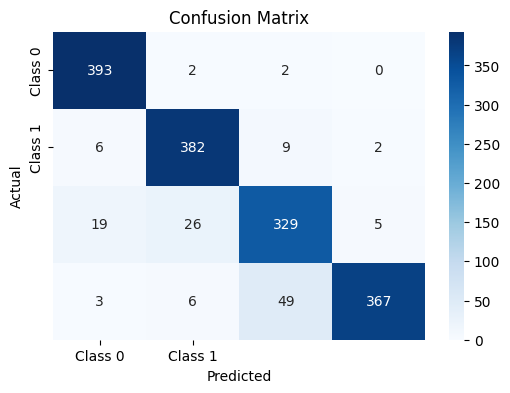

In [4]:
model = RandomForestClassifier(random_state=42)

# Start an MLflow run
with mlf.start_run():

    nEstimators=30
    maxDepth=None
    minSamplesSplit=2
    maxFeatures='sqrt'
    
    # Train the Random Forest model
    model = RandomForestClassifier(n_estimators=nEstimators, max_depth=maxDepth, min_samples_split=minSamplesSplit, max_features=maxFeatures, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Log parameters and metrics
    mlf.log_param("n_estimators", nEstimators)
    mlf.log_param("max_depth", maxDepth)
    mlf.log_param("min_samples_split", minSamplesSplit)
    mlf.log_param("max_features", maxFeatures)
    mlf.log_metric("accuracy", accuracy)
    mlf.log_metric("precision", precision)
    mlf.log_metric("recall", recall)
    mlf.log_metric("f1_score", f1)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot as an artifact
    cm_filepath = "confusion_matrix_rf.png"
    plt.savefig(cm_filepath)
    mlf.log_artifact(cm_filepath)

    print("Confusion matrix plot logged as an artifact.")


### Register Best Model :

In [34]:
with mlf.start_run(nested=True):
    # Define the model URI
    model_uri = f"runs:/{mlf.active_run().info.run_id}/model_brain_tumor_classifier"

    # Ensure input example is simple and serializable
    input_example = X_train[:1]  # First row of training data

    # Log the Random Forest model
    mlf.sklearn.log_model(
        sk_model=model,
        artifact_path="model_brain_tumor_classifier",
        input_example=input_example
    )

    # Register the model
    mlf.register_model(model_uri, "BrainTumorClassifierBestModel")


C:\Cours\Processus Data\TP_Environment_Setup\Tp1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Successfully registered model 'BrainTumorClassifierBestModel'.
2024/12/11 03:50:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BrainTumorClassifierBestModel, version 1
Created version '1' of model 'BrainTumorClassifierBestModel'.
2024/12/11 03:50:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run fearless-wren-642 at: http://127.0.0.1:5000/#/experiments/286751057660019599/runs/1203455879ff42b89d9a409757d658df.
2024/12/11 03:50:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/286751057660019599.


In [5]:
experiment = mlf.get_experiment_by_name("Brain_Tumor_Classification")
experiment_id = experiment.experiment_id

print(f"Experiment ID: {experiment_id}")
runs = mlf.search_runs(experiment_ids=experiment_id)

best = runs.sort_values(by="metrics.accuracy", ascending=False).iloc[0]

best_id = best["run_id"]

print(f"Best Run ID: {best_id}")
print(f"Best Run Metrics: {best[['metrics.accuracy']]}")

best_uri = f"runs:/{best_id}/model_brain_tumor_classifier"

best_uri

Experiment ID: 286751057660019599
Best Run ID: dd416f4296e647aa8306e7f24fc06a3a
Best Run Metrics: metrics.accuracy    0.919375
Name: 0, dtype: object


'runs:/dd416f4296e647aa8306e7f24fc06a3a/model_brain_tumor_classifier'

#### Model explainability and interpretability :

#### LIME :

In [8]:
import lime
from lime import lime_tabular

In [9]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=[f"pixel_{i}" for i in range(X_train.shape[1])],
    class_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
    discretize_continuous=True
)

In [10]:
sample_index = 0
sample = X_test[sample_index].reshape(1, -1)

In [11]:
def predict_proba_with_mlflow(input_data):
    """
    Utilise le modèle MLflow pour prédire les probabilités de chaque classe.
    """
    input_df = pd.DataFrame(input_data, columns=[f"pixel_{i}" for i in range(input_data.shape[1])])
    probabilities = model.predict_proba(input_df)  # Retourne les scores de probabilité
    return probabilities

In [12]:
test_sample = X_test[:5]  
print(predict_proba_with_mlflow(test_sample)) 

[[0.23333333 0.06666667 0.66666667 0.03333333]
 [0.66666667 0.06666667 0.23333333 0.03333333]
 [0.         0.         0.06666667 0.93333333]
 [0.         0.1        0.56666667 0.33333333]
 [0.76666667 0.13333333 0.1        0.        ]]


c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [13]:
exp = lime_explainer.explain_instance(
    data_row=sample.flatten(),
    predict_fn=predict_proba_with_mlflow,
    num_features=10,
    top_labels=4
)

c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
class_to_explain = 0
exp.show_in_notebook(show_table=True, show_all=False)

In [16]:
exp.save_to_file(f"lime_explanation_sample_{sample_index}.html")

Explication enregistrée sous forme d'image : lime_explanation_sample_0.png


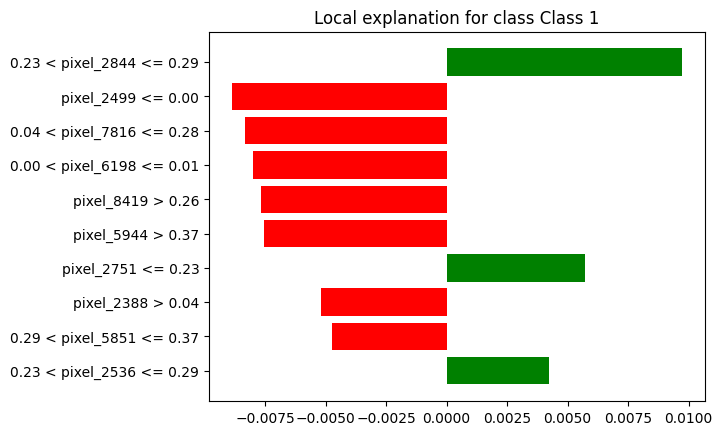

In [ ]:
fig = exp.as_pyplot_figure()

fig.savefig(f"lime_explanation_sample_{sample_index}.png")

print(f"Explication enregistrée sous forme d'image : lime_explanation_sample_{sample_index}.png")

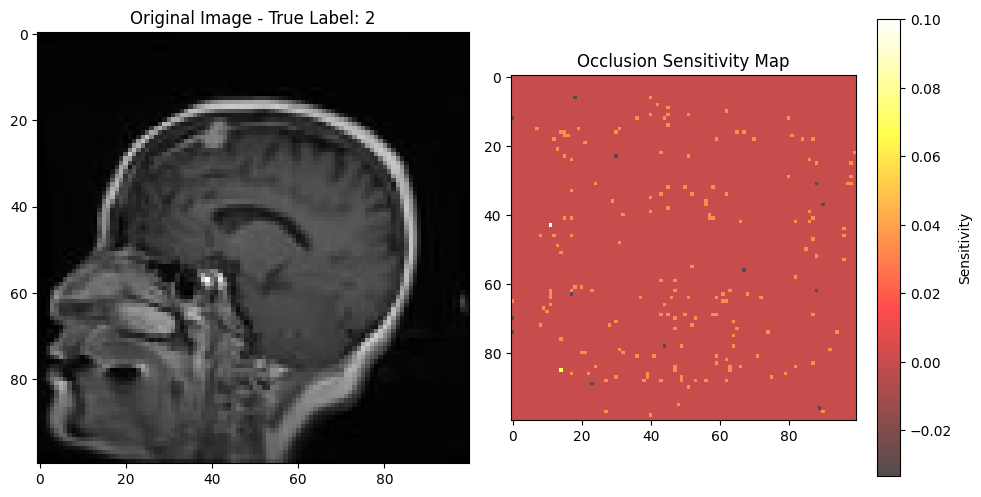

In [15]:
# Adjust based on the original image dimensions before flattening
original_image_shape = (100, 100)  # Replace with your image's actual dimensions

def occlusion_sensitivity(model, image, mask_size, feature_names):
    """
    Compute occlusion sensitivity for a given image.
    
    Parameters:
        model: Trained Random Forest model.
        image: Input image (as a flattened feature vector).
        mask_size: Size of the occlusion mask.
        feature_names: Names or indices of image features.
    
    Returns:
        Sensitivity map (same shape as the input image).
    """
    original_prediction = model.predict_proba([image])[0]
    sensitivity_map = np.zeros(len(feature_names))
    
    for i in range(len(feature_names)):
        # Create a copy of the image with one feature masked
        masked_image = image.copy()
        masked_image[i] = 0  # Mask the feature
        
        # Predict with the masked image
        masked_prediction = model.predict_proba([masked_image])[0]
        
        # Compute sensitivity as the change in the target class probability
        sensitivity_map[i] = original_prediction.max() - masked_prediction.max()
    
    # Reshape the sensitivity map back to the image shape
    return sensitivity_map.reshape(original_image_shape)

# Example use case
image_index = 5
image = X_test[image_index]  # Replace with a specific image from your test set
label = y_test[image_index]

# Generate occlusion sensitivity map
sensitivity_map = occlusion_sensitivity(model, image, mask_size=1, feature_names=range(X_train.shape[1]))

# Visualize the sensitivity map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.reshape(original_image_shape), cmap='gray')  # Adjust dimensions for your images
plt.title(f"Original Image - True Label: {label}")

plt.subplot(1, 2, 2)
plt.imshow(sensitivity_map, cmap='hot', alpha=0.7)
plt.colorbar(label="Sensitivity")
plt.title("Occlusion Sensitivity Map")

plt.tight_layout()
plt.show()

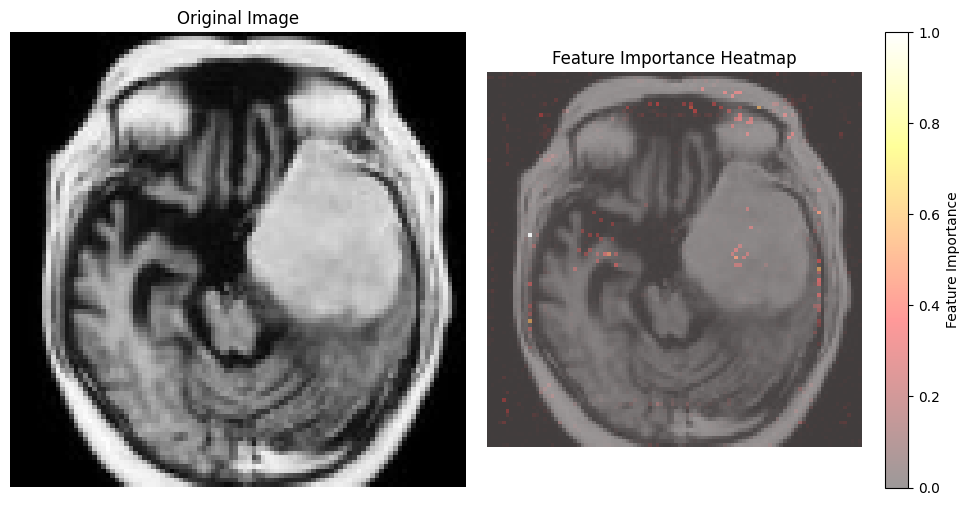

In [16]:
# Extract feature importances
feature_importances = model.feature_importances_

# Reshape feature importances to match the original image dimensions
importance_map = feature_importances.reshape(original_image_shape)

# Normalize the importance map for better visualization
importance_map = (importance_map - np.min(importance_map)) / (np.max(importance_map) - np.min(importance_map))

# Select an image to overlay the heatmap
image_index = 0
original_image = X_test[image_index].reshape(original_image_shape)  # Adjust for your image dimensions

# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Plot the feature importance heatmap overlay
plt.subplot(1, 2, 2)
plt.imshow(original_image, cmap='gray', alpha=0.6)  # Original image in the background
plt.imshow(importance_map, cmap='hot', alpha=0.4)  # Heatmap overlay
plt.colorbar(label="Feature Importance")
plt.title("Feature Importance Heatmap")
plt.axis("off")

plt.tight_layout()
plt.show()

> We can see that certain pixels increase the probability of the class.

> The feature sensitivity shows us the areas considered important, but we cannot know whether the model has correctly captured the characteristics of the tumour types: the opinion of a medical expert is required.

### B - Convolutional neural network 

In [2]:
metadata = pd.read_csv('dataset/balanced_metadata.csv')
image_folder = 'dataset/balanced_dataset/'
images = []
labels = []
for i, row in metadata.iterrows():
    img_path = os.path.join(image_folder, row['image_name'])
    img = load_img(img_path, target_size=(128, 128))
    images.append(img_to_array(img))
    labels.append(row['target'])

images = np.array(images) / 255.0  # Normalisation
labels = np.array(labels)
print(labels.shape)
print(labels[:10])

(8000,)
[3 3 3 3 3 3 3 3 3 3]


In [3]:
labels = to_categorical(labels, num_classes=4)
print(images.shape)  
print(labels.shape)

(8000, 128, 128, 3)
(8000, 4)


In [4]:
def build_cnn_model(input_shape=(128, 128, 3), num_classes=4, optimizer='adam',
                    dropout_rate=0.5, activation='relu', filters=32, kernel_size=(3, 3)):
    model = Sequential()

    # Première couche convolutionnelle
    model.add(Conv2D(filters, kernel_size, activation=activation, input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Deuxième couche convolutionnelle
    model.add(Conv2D(filters * 2, kernel_size, activation=activation))
    model.add(MaxPooling2D((2, 2)))

    # Troisième couche convolutionnelle
    model.add(Conv2D(filters * 4, kernel_size, activation=activation))
    model.add(MaxPooling2D((2, 2)))

    # Aplatir les résultats des couches précédentes
    model.add(Flatten())

    # Couches entièrement connectées
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))  # Dropout pour éviter l'overfitting
    model.add(Dense(num_classes, activation='softmax'))  # Classification multi-classe

    # Choisir l'optimiseur basé sur l'argument
    if optimizer == 'adam':
        optimizer_instance = Adam()
    elif optimizer == 'sgd':
        optimizer_instance = SGD()
    elif optimizer == 'rmsprop':
        optimizer_instance = RMSprop()

    # Compiler le modèle avec les métriques supplémentaires
    model.compile(optimizer=optimizer_instance, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', Recall(), AUC()])

    return model

In [ ]:
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],  # Optimiseur à tester
    'dropout_rate': [0.3, 0.5, 0.7],  # Taux de dropout
    'activation': ['relu', 'tanh', 'elu'],  # Fonction d'activation des couches
    'filters': [32],  # Nombre de filtres dans les couches convolutionnelles
    'kernel_size': [(3, 3)],  # Taille des noyaux de convolution
    'batch_size': [16, 32],  # Taille des mini-batchs
    'epochs': [5, 10]  # Nombre d'époques
}

" # Grid search des paramètres\nparam_grid = {\n    'optimizer': ['adam', 'sgd', 'rmsprop'],  # Optimiseur à tester\n    'dropout_rate': [0.3, 0.5, 0.7],  # Taux de dropout\n    'activation': ['relu', 'tanh', 'elu'],  # Fonction d'activation des couches\n    'filters': [32],  # Nombre de filtres dans les couches convolutionnelles\n    'kernel_size': [(3, 3)],  # Taille des noyaux de convolution\n    'batch_size': [16, 32],  # Taille des mini-batchs\n    'epochs': [5, 10]  # Nombre d'époques\n}"

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
# Paramètres pour la validation croisée
num_folds = 3
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [11]:
results = []
nb = 4
for filters in param_grid['filters']:
    for dropout_rate in param_grid['dropout_rate']:
        nb = nb + 1

        # Paramètres du modèle
        params = {
            'filters': filters,
            'kernel_size': param_grid['kernel_size'],
            'dropout_rate': dropout_rate,
            'batch_size': param_grid['batch_size'],
            'epochs': param_grid['epochs'],
            'optimizer': param_grid['optimizer']
        }
        print(f"Starting experiment {nb} with parameters: {params}")

        with mlflow.start_run() as run:
            mlflow.set_tag("mlflow.runName", f"CNN : Experiment {nb}")
            mlflow.set_tag("Experiment Info", f"Experiment {nb} for CNN with parameters : {params}")
            mlflow.log_params(params)

            fold_metrics = []
            for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, np.argmax(y_train, axis=1))):
                print(f"Fold {fold + 1}/{num_folds}")

                X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

                model = build_cnn_model(
                    input_shape=(128, 128, 3),
                    num_classes=4,
                    optimizer=params['optimizer'],
                    dropout_rate=params['dropout_rate'],
                    activation='relu',
                    filters=params['filters'],
                    kernel_size=params['kernel_size']
                )
                early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                history = model.fit(
                    X_fold_train, y_fold_train,
                    validation_data=(X_fold_val, y_fold_val),
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    callbacks=[early_stopping],
                    verbose=1
                )

                # Prédictions et métriques sur le fold
                y_val_pred = model.predict(X_fold_val)
                y_val_pred_classes = np.argmax(y_val_pred, axis=1)
                y_val_actual_classes = np.argmax(y_fold_val, axis=1)

                accuracy = accuracy_score(y_val_actual_classes, y_val_pred_classes)
                precision = precision_score(y_val_actual_classes, y_val_pred_classes, average='weighted')
                recall = recall_score(y_val_actual_classes, y_val_pred_classes, average='weighted')
                f1 = f1_score(y_val_actual_classes, y_val_pred_classes, average='weighted')
                auc_roc = roc_auc_score(y_fold_val, y_val_pred, multi_class='ovr')

                fold_metrics.append({
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'auc_roc': auc_roc
                })

                # Logging des métriques pour chaque fold
                mlflow.log_metric(f"fold_{fold + 1}_accuracy", accuracy)
                mlflow.log_metric(f"fold_{fold + 1}_precision", precision)
                mlflow.log_metric(f"fold_{fold + 1}_recall", recall)
                mlflow.log_metric(f"fold_{fold + 1}_f1", f1)
                mlflow.log_metric(f"fold_{fold + 1}_auc_roc", auc_roc)

            # Moyennes des métriques sur tous les folds
            avg_accuracy = np.mean([m['accuracy'] for m in fold_metrics])
            avg_precision = np.mean([m['precision'] for m in fold_metrics])
            avg_recall = np.mean([m['recall'] for m in fold_metrics])
            avg_f1 = np.mean([m['f1'] for m in fold_metrics])
            avg_auc_roc = np.mean([m['auc_roc'] for m in fold_metrics])

            mlflow.log_metric("avg_accuracy", avg_accuracy)
            mlflow.log_metric("avg_precision", avg_precision)
            mlflow.log_metric("avg_recall", avg_recall)
            mlflow.log_metric("avg_f1", avg_f1)
            mlflow.log_metric("avg_auc_roc", avg_auc_roc)

            # Prédictions finales sur X_test
            y_test_pred = model.predict(X_test)
            y_test_pred_classes = np.argmax(y_test_pred, axis=1)
            y_test_actual_classes = np.argmax(y_test, axis=1)

            # Calcul des métriques sur le test
            test_accuracy = accuracy_score(y_test_actual_classes, y_test_pred_classes)
            test_precision = precision_score(y_test_actual_classes, y_test_pred_classes, average='weighted')
            test_recall = recall_score(y_test_actual_classes, y_test_pred_classes, average='weighted')
            test_f1 = f1_score(y_test_actual_classes, y_test_pred_classes, average='weighted')

            mlflow.log_metric("test_accuracy", test_accuracy)
            mlflow.log_metric("test_precision", test_precision)
            mlflow.log_metric("test_recall", test_recall)
            mlflow.log_metric("test_f1", test_f1)

            predictions_df = pd.DataFrame({"Actual": y_test_actual_classes, "Predicted": y_test_pred_classes})
            predictions_csv_path = "tmp/predictions.csv"
            predictions_df.to_csv(predictions_csv_path, index=False)
            mlflow.log_artifact(predictions_csv_path, artifact_path="predictions")

            # Matrice de confusion
            matrix = confusion_matrix(y_test_actual_classes, y_test_pred_classes)
            plt.figure(figsize=(8, 6))
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
            plt.title("Confusion Matrix")
            cf_matrix_path = "tmp/confusion_matrix.png"
            plt.savefig(cf_matrix_path)
            plt.close()
            mlflow.log_artifact(cf_matrix_path, artifact_path="cf_matrix")

            # Courbe ROC AUC
            fpr, tpr, _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Receiver Operating Characteristic")
            plt.legend(loc="lower right")
            roc_curve_path = "tmp/roc_curve.png"
            plt.savefig(roc_curve_path)
            plt.close()
            mlflow.log_artifact(roc_curve_path, artifact_path="roc_curve")

            # Enregistrement du modèle final
            mlflow.keras.log_model(model, "cnn_model")
            signature = infer_signature(X_train, model.predict(X_train))
            model_info = mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="cnn_model",
                signature=signature,
                input_example=X_train[:1],
                registered_model_name="convolutional-neural-network",
            )


Starting experiment 5 with parameters: {'filters': 16, 'kernel_size': (3, 3), 'dropout_rate': 0.3, 'batch_size': 32, 'epochs': 10, 'optimizer': 'rmsprop'}
Fold 1/3


c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.4786 - auc: 0.7424 - loss: 1.2509 - recall: 0.1993 - val_accuracy: 0.6550 - val_auc: 0.8808 - val_loss: 0.8506 - val_recall: 0.5958
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.7186 - auc: 0.9147 - loss: 0.7003 - recall: 0.6458 - val_accuracy: 0.7903 - val_auc: 0.9532 - val_loss: 0.5176 - val_recall: 0.7663
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.8038 - auc: 0.9513 - loss: 0.5264 - recall: 0.7657 - val_accuracy: 0.8342 - val_auc: 0.9664 - val_loss: 0.4289 - val_recall: 0.8125
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8368 - auc: 0.9688 - loss: 0.4128 - recall: 0.8157 - val_accuracy: 0.8207 - val_auc: 0.9633 - val_loss: 0.4630 - val_recall: 0.8079
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8689 - auc: 0.9775 - loss: 0.3486 - recall: 0.8592 - val_accuracy: 0.8576 - val_auc: 0.9732 - val_loss: 0.3788 - val_recall: 0.8483
Epoc

c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.4554 - auc_1: 0.7430 - loss: 1.1796 - recall_1: 0.2304 - val_accuracy: 0.6719 - val_auc_1: 0.9015 - val_loss: 0.7575 - val_recall_1: 0.6397
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.7383 - auc_1: 0.9228 - loss: 0.6656 - recall_1: 0.6795 - val_accuracy: 0.7827 - val_auc_1: 0.9470 - val_loss: 0.5510 - val_recall_1: 0.7639
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.7855 - auc_1: 0.9498 - loss: 0.5374 - recall_1: 0.7599 - val_accuracy: 0.8278 - val_auc_1: 0.9647 - val_loss: 0.4534 - val_recall_1: 0.8079
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8487 - auc_1: 0.9717 - loss: 0.3964 - recall_1: 0.8260 - val_accuracy: 0.8530 - val_auc_1: 0.9697 - val_loss: 0.4142 - val_recall_1: 0.8389
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8923 - auc_1: 0.9837 - loss: 0.2917 - recall_1: 0.8832 - val_accuracy: 0.8723 - val_auc_1: 0.9777 - val_loss: 0.3546

c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.4867 - auc_2: 0.7544 - loss: 1.1439 - recall_2: 0.2462 - val_accuracy: 0.7280 - val_auc_2: 0.9279 - val_loss: 0.6429 - val_recall_2: 0.6975
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.7349 - auc_2: 0.9226 - loss: 0.6650 - recall_2: 0.6767 - val_accuracy: 0.8113 - val_auc_2: 0.9510 - val_loss: 0.5613 - val_recall_2: 0.7468
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.8036 - auc_2: 0.9555 - loss: 0.4999 - recall_2: 0.7675 - val_accuracy: 0.8505 - val_auc_2: 0.9691 - val_loss: 0.4145 - val_recall_2: 0.8265
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8378 - auc_2: 0.9688 - loss: 0.4137 - recall_2: 0.8164 - val_accuracy: 0.8640 - val_auc_2: 0.9728 - val_loss: 0.3874 - val_recall_2: 0.8470
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.8792 - auc_2: 0.9793 - loss: 0.3326 - recall_2: 0.8664 - val_accuracy: 0.8728 - val_auc_2: 0.9761 - val_loss: 0.3547

2024/12/11 03:00:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/11 03:01:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Registered model 'convolutional-neural-network' already exists. Creating a new version of this model...
2024/12/11 03:01:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: convolutional-neural-network, version 5
Created version '5' of model 'convolutional-neural-network'.


🏃 View run CNN : Experiment 5 at: http://127.0.0.1:5000/#/experiments/344762819335167390/runs/e9c7c05b3a9a44eab98575869625bfcb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/344762819335167390
Starting experiment 6 with parameters: {'filters': 16, 'kernel_size': (3, 3), 'dropout_rate': 0.5, 'batch_size': 32, 'epochs': 10, 'optimizer': 'rmsprop'}
Fold 1/3


c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.4741 - auc_3: 0.7534 - loss: 1.1330 - recall_3: 0.2114 - val_accuracy: 0.7077 - val_auc_3: 0.9009 - val_loss: 0.7765 - val_recall_3: 0.6286
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.7048 - auc_3: 0.9083 - loss: 0.7260 - recall_3: 0.6255 - val_accuracy: 0.6819 - val_auc_3: 0.8925 - val_loss: 0.8431 - val_recall_3: 0.6561
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.7503 - auc_3: 0.9344 - loss: 0.6138 - recall_3: 0.7058 - val_accuracy: 0.8125 - val_auc_3: 0.9558 - val_loss: 0.5030 - val_recall_3: 0.7909
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8055 - auc_3: 0.9557 - loss: 0.5013 - recall_3: 0.7681 - val_accuracy: 0.7967 - val_auc_3: 0.9551 - val_loss: 0.5000 - val_recall_3: 0.7768
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8315 - auc_3: 0.9650 - loss: 0.4415 - recall_3: 0.8094 - val_accuracy: 0.8512 - val_auc_3: 0.9703 - val_l

c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.4719 - auc_4: 0.7379 - loss: 1.2205 - recall_4: 0.2362 - val_accuracy: 0.7059 - val_auc_4: 0.9216 - val_loss: 0.7059 - val_recall_4: 0.6028
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.7288 - auc_4: 0.9158 - loss: 0.7084 - recall_4: 0.6399 - val_accuracy: 0.7276 - val_auc_4: 0.9121 - val_loss: 0.7142 - val_recall_4: 0.6462
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8006 - auc_4: 0.9481 - loss: 0.5470 - recall_4: 0.7439 - val_accuracy: 0.7926 - val_auc_4: 0.9543 - val_loss: 0.5081 - val_recall_4: 0.7551
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8175 - auc_4: 0.9599 - loss: 0.4772 - recall_4: 0.7807 - val_accuracy: 0.7709 - val_auc_4: 0.9537 - val_loss: 0.5192 - val_recall_4: 0.7528
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.8448 - auc_4: 0.9702 - loss: 0.4055 - recall_4: 0.8262 - val_accuracy: 0.8442 - val_auc_4: 0.9682 - val_l

c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.4625 - auc_5: 0.7381 - loss: 1.2000 - recall_5: 0.2116 - val_accuracy: 0.7204 - val_auc_5: 0.9132 - val_loss: 0.7226 - val_recall_5: 0.5979
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6860 - auc_5: 0.9060 - loss: 0.7321 - recall_5: 0.6040 - val_accuracy: 0.7409 - val_auc_5: 0.9405 - val_loss: 0.5837 - val_recall_5: 0.7075
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.7728 - auc_5: 0.9390 - loss: 0.5916 - recall_5: 0.7089 - val_accuracy: 0.8406 - val_auc_5: 0.9650 - val_loss: 0.4569 - val_recall_5: 0.8148
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.7987 - auc_5: 0.9547 - loss: 0.5058 - recall_5: 0.7646 - val_accuracy: 0.8623 - val_auc_5: 0.9678 - val_loss: 0.4230 - val_recall_5: 0.8464
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.8444 - auc_5: 0.9689 - loss: 0.4188 - recall_5: 0.8184 - val_accuracy: 0.8312 - val_auc_5: 0.9686 - val_

2024/12/11 03:05:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/11 03:05:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Registered model 'convolutional-neural-network' already exists. Creating a new version of this model...
2024/12/11 03:06:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: convolutional-neural-network, version 6
Created version '6' of model 'convolutional-neural-network'.


🏃 View run CNN : Experiment 6 at: http://127.0.0.1:5000/#/experiments/344762819335167390/runs/8e0191b3db8a480baaa5e8efb599c86b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/344762819335167390
Starting experiment 7 with parameters: {'filters': 32, 'kernel_size': (3, 3), 'dropout_rate': 0.3, 'batch_size': 32, 'epochs': 10, 'optimizer': 'rmsprop'}
Fold 1/3


c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 27s 244ms/step - accuracy: 0.4536 - auc_6: 0.7171 - loss: 1.2774 - recall_6: 0.2080 - val_accuracy: 0.6731 - val_auc_6: 0.9085 - val_loss: 0.7153 - val_recall_6: 0.6069
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - accuracy: 0.6746 - auc_6: 0.9028 - loss: 0.7390 - recall_6: 0.5996 - val_accuracy: 0.8020 - val_auc_6: 0.9577 - val_loss: 0.4879 - val_recall_6: 0.7756
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 222ms/step - accuracy: 0.8017 - auc_6: 0.9548 - loss: 0.5061 - recall_6: 0.7767 - val_accuracy: 0.8178 - val_auc_6: 0.9652 - val_loss: 0.4434 - val_recall_6: 0.7967
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.8365 - auc_6: 0.9716 - loss: 0.3938 - recall_6: 0.8195 - val_accuracy: 0.8477 - val_auc_6: 0.9695 - val_loss: 0.4066 - val_recall_6: 0.8342
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 230ms/step - accuracy: 0.8807 - auc_6: 0.9830 - loss: 0.3017 - recall_6: 0.8702 - val_accuracy: 0.8448 - val_auc_6: 0.96

c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - accuracy: 0.4945 - auc_7: 0.7374 - loss: 1.3664 - recall_7: 0.2336 - val_accuracy: 0.6725 - val_auc_7: 0.9086 - val_loss: 0.7140 - val_recall_7: 0.5917
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 234ms/step - accuracy: 0.7315 - auc_7: 0.9223 - loss: 0.6673 - recall_7: 0.6726 - val_accuracy: 0.8125 - val_auc_7: 0.9589 - val_loss: 0.4879 - val_recall_7: 0.7780
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 233ms/step - accuracy: 0.8023 - auc_7: 0.9565 - loss: 0.4939 - recall_7: 0.7694 - val_accuracy: 0.7381 - val_auc_7: 0.9444 - val_loss: 0.6172 - val_recall_7: 0.7241
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - accuracy: 0.8548 - auc_7: 0.9733 - loss: 0.3799 - recall_7: 0.8431 - val_accuracy: 0.8295 - val_auc_7: 0.9700 - val_loss: 0.4110 - val_recall_7: 0.8231
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.8914 - auc_7: 0.9829 - loss: 0.3020 - recall_7: 0.8823 - val_accuracy: 0.8483 - val_auc_7: 0.97

c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 29s 260ms/step - accuracy: 0.4482 - auc_8: 0.7312 - loss: 1.2742 - recall_8: 0.2014 - val_accuracy: 0.5780 - val_auc_8: 0.8566 - val_loss: 0.9089 - val_recall_8: 0.4924
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 27s 251ms/step - accuracy: 0.7055 - auc_8: 0.9090 - loss: 0.7228 - recall_8: 0.6054 - val_accuracy: 0.7263 - val_auc_8: 0.9343 - val_loss: 0.6252 - val_recall_8: 0.6987
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - accuracy: 0.7727 - auc_8: 0.9466 - loss: 0.5466 - recall_8: 0.7355 - val_accuracy: 0.8558 - val_auc_8: 0.9686 - val_loss: 0.4356 - val_recall_8: 0.8236
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step - accuracy: 0.8293 - auc_8: 0.9613 - loss: 0.4635 - recall_8: 0.8049 - val_accuracy: 0.8494 - val_auc_8: 0.9686 - val_loss: 0.4183 - val_recall_8: 0.8306
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 244ms/step - accuracy: 0.8583 - auc_8: 0.9767 - loss: 0.3573 - recall_8: 0.8449 - val_accuracy: 0.8810 - val_auc_8: 0.97

2024/12/11 03:19:03 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/11 03:19:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Registered model 'convolutional-neural-network' already exists. Creating a new version of this model...
2024/12/11 03:19:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: convolutional-neural-network, version 7
Created version '7' of model 'convolutional-neural-network'.


🏃 View run CNN : Experiment 7 at: http://127.0.0.1:5000/#/experiments/344762819335167390/runs/4f91d4bdd3e248269818fc844b689035
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/344762819335167390
Starting experiment 8 with parameters: {'filters': 32, 'kernel_size': (3, 3), 'dropout_rate': 0.5, 'batch_size': 32, 'epochs': 10, 'optimizer': 'rmsprop'}
Fold 1/3


c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 230ms/step - accuracy: 0.4169 - auc_9: 0.7072 - loss: 1.2998 - recall_9: 0.1726 - val_accuracy: 0.7323 - val_auc_9: 0.9224 - val_loss: 0.6745 - val_recall_9: 0.6508
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - accuracy: 0.7026 - auc_9: 0.9100 - loss: 0.7237 - recall_9: 0.6064 - val_accuracy: 0.6954 - val_auc_9: 0.9244 - val_loss: 0.6413 - val_recall_9: 0.6462
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - accuracy: 0.7567 - auc_9: 0.9341 - loss: 0.6176 - recall_9: 0.7042 - val_accuracy: 0.8114 - val_auc_9: 0.9634 - val_loss: 0.4529 - val_recall_9: 0.7920
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.8071 - auc_9: 0.9582 - loss: 0.4842 - recall_9: 0.7766 - val_accuracy: 0.8354 - val_auc_9: 0.9671 - val_loss: 0.4246 - val_recall_9: 0.8237
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 236ms/step - accuracy: 0.8581 - auc_9: 0.9748 - loss: 0.3730 - recall_9: 0.8373 - val_accuracy: 0.8670 - val_auc_9: 0.97

c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 236ms/step - accuracy: 0.4515 - auc_10: 0.7430 - loss: 1.1476 - recall_10: 0.2133 - val_accuracy: 0.7118 - val_auc_10: 0.9112 - val_loss: 0.7160 - val_recall_10: 0.6544
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 216ms/step - accuracy: 0.7375 - auc_10: 0.9227 - loss: 0.6699 - recall_10: 0.6673 - val_accuracy: 0.8166 - val_auc_10: 0.9602 - val_loss: 0.4751 - val_recall_10: 0.7797
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 210ms/step - accuracy: 0.7978 - auc_10: 0.9509 - loss: 0.5236 - recall_10: 0.7628 - val_accuracy: 0.8131 - val_auc_10: 0.9609 - val_loss: 0.4809 - val_recall_10: 0.7657
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 207ms/step - accuracy: 0.8289 - auc_10: 0.9654 - loss: 0.4378 - recall_10: 0.8038 - val_accuracy: 0.7891 - val_auc_10: 0.9472 - val_loss: 0.5758 - val_recall_10: 0.7768
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - accuracy: 0.8625 - auc_10: 0.9775 - loss: 0.3527 - recall_10: 0.8447 - val_accuracy: 0.8735

c:\Users\user\Documents\GitHub\ML-Excuses\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - accuracy: 0.4708 - auc_11: 0.7434 - loss: 1.2351 - recall_11: 0.2179 - val_accuracy: 0.7210 - val_auc_11: 0.9112 - val_loss: 0.7383 - val_recall_11: 0.6671
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 216ms/step - accuracy: 0.7124 - auc_11: 0.9223 - loss: 0.6616 - recall_11: 0.6532 - val_accuracy: 0.8218 - val_auc_11: 0.9553 - val_loss: 0.5215 - val_recall_11: 0.7825
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.7855 - auc_11: 0.9485 - loss: 0.5362 - recall_11: 0.7471 - val_accuracy: 0.8523 - val_auc_11: 0.9680 - val_loss: 0.4369 - val_recall_11: 0.8165
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - accuracy: 0.8334 - auc_11: 0.9682 - loss: 0.4208 - recall_11: 0.8095 - val_accuracy: 0.8710 - val_auc_11: 0.9737 - val_loss: 0.3764 - val_recall_11: 0.8576
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 213ms/step - accuracy: 0.8748 - auc_11: 0.9780 - loss: 0.3429 - recall_11: 0.8552 - val_accuracy: 0.8693

2024/12/11 03:30:44 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/11 03:30:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Registered model 'convolutional-neural-network' already exists. Creating a new version of this model...
2024/12/11 03:31:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: convolutional-neural-network, version 8


🏃 View run CNN : Experiment 8 at: http://127.0.0.1:5000/#/experiments/344762819335167390/runs/9af40823da7b4311a2d37e347feeb674
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/344762819335167390


Created version '8' of model 'convolutional-neural-network'.


In [7]:
runs = mlflow.search_runs(experiment_ids=experiment_id)

best_cnn = runs.sort_values(by="metrics.test_accuracy", ascending=False).iloc[0]

best_cnn_id = best_cnn["run_id"]

print(f"Best Run ID: {best_cnn_id}")
print(f"Best Run Metrics: {best_cnn[['metrics.avg_accuracy', 'metrics.avg_f1', 'metrics.test_accuracy', 'metrics.test_f1']]}")

best_cnn_uri = f"runs:/{best_cnn_id}/cnn_model"

best_cnn_uri

Best Run ID: 7b6ab6dae00443878f8e89536fcb2bd1
Best Run Metrics: metrics.avg_accuracy     0.911528
metrics.avg_f1           0.911026
metrics.test_accuracy    0.914375
metrics.test_f1          0.914609
Name: 5, dtype: object


'runs:/7b6ab6dae00443878f8e89536fcb2bd1/cnn_model'

In [13]:
mlflow.register_model(
        model_uri=best_cnn_uri,
        name="BrainTumor_BestCNN"
    )

Successfully registered model 'BrainTumor_BestCNN'.
2024/12/11 03:31:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BrainTumor_BestCNN, version 1
Created version '1' of model 'BrainTumor_BestCNN'.


<ModelVersion: aliases=[], creation_timestamp=1733884263385, current_stage='None', description='', last_updated_timestamp=1733884263385, name='BrainTumor_BestCNN', run_id='7b6ab6dae00443878f8e89536fcb2bd1', run_link='', source='mlflow-artifacts:/344762819335167390/7b6ab6dae00443878f8e89536fcb2bd1/artifacts/cnn_model', status='READY', status_message='', tags={}, user_id='', version='1'>

![Capture d'écran 2024-12-11 123036.png](<attachment:Capture d'écran 2024-12-11 123036.png>)
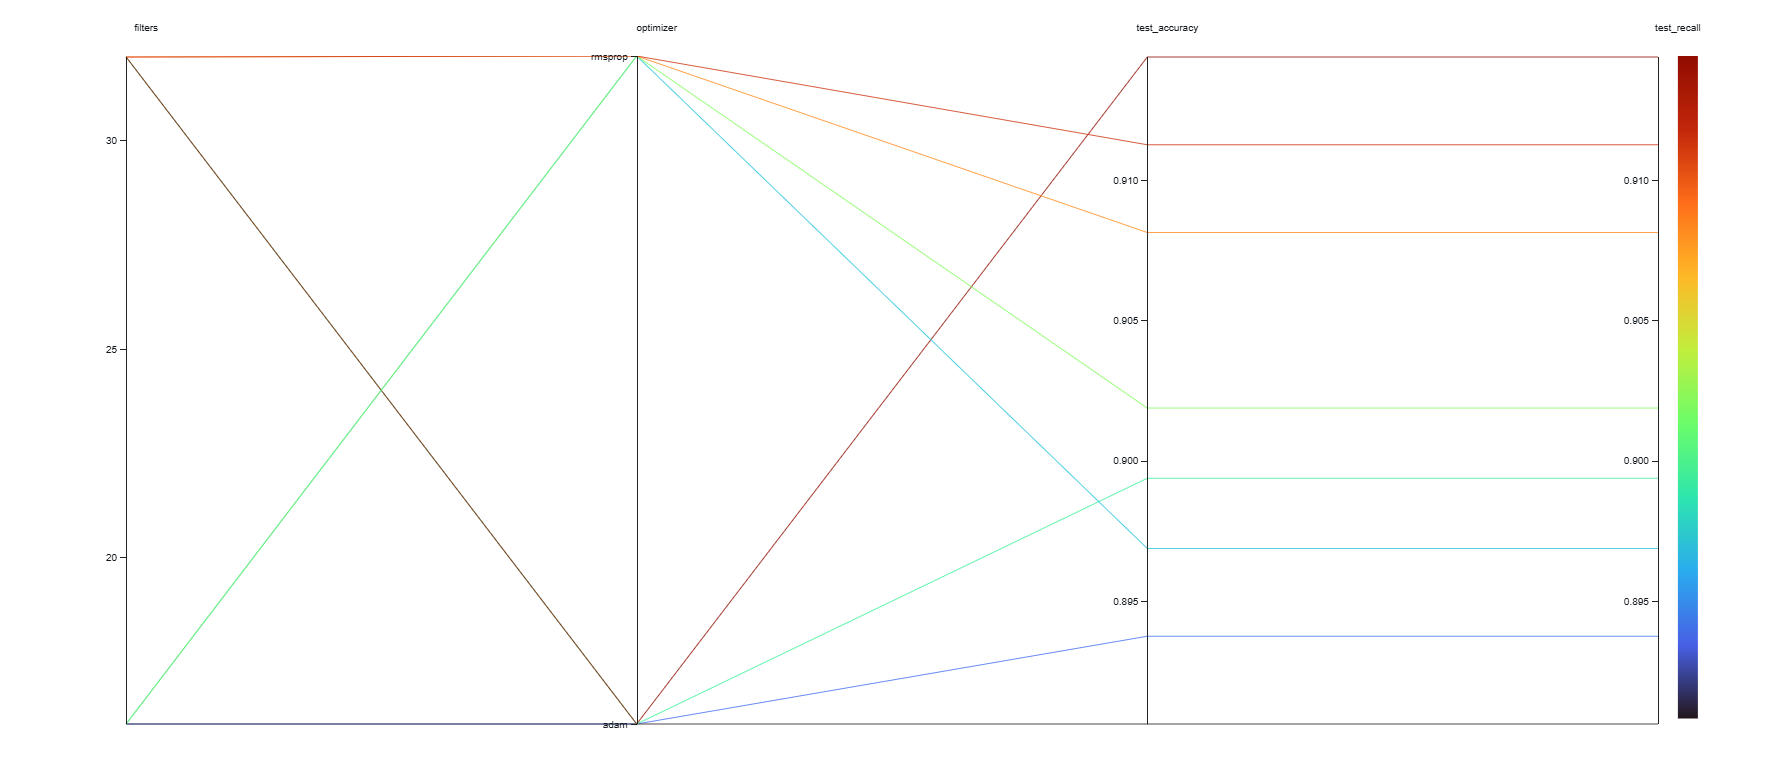

## c- Deep Learning Model Implementations




In [2]:
image_dir = 'dataset/balanced_dataset'
image_size = (128, 128)

def load_images_and_labels(data, image_dir, image_size):
    images, labels = [], []
    for _, row in data.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        if os.path.exists(image_path):
            img = load_img(image_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(row['target'])
        else:
            print(f"Image not found: {image_path}")
    return np.array(images), np.array(labels)

data = pd.read_csv('dataset/balanced_metadata.csv')
images, labels = load_images_and_labels(data, image_dir, image_size)

# One-hot encode labels
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

### Model 1 - Shallow Neural Network


In [23]:
# Model 1 - Shallow Neural Network
def build_shallow_nn(input_shape, num_classes, learning_rate):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Custom callback for logging metrics per epoch
class MlflowCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            # Log metrics for the current epoch
            mlflow.log_metric("train_accuracy", logs["accuracy"], step=epoch)
            mlflow.log_metric("val_accuracy", logs["val_accuracy"], step=epoch)
            mlflow.log_metric("train_loss", logs["loss"], step=epoch)
            mlflow.log_metric("val_loss", logs["val_loss"], step=epoch)
            
            # Calculate and log precision and recall
            X_val, y_val = self.validation_data
            y_pred = self.model.predict(X_val)
            y_pred_classes = y_pred.argmax(axis=1)
            y_true = y_val.argmax(axis=1)
            precision = precision_score(y_true, y_pred_classes, average='weighted')
            recall = recall_score(y_true, y_pred_classes, average='weighted')
            mlflow.log_metric("precision", precision, step=epoch)
            mlflow.log_metric("recall", recall, step=epoch)

# Initialize MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000") 
mlflow.set_experiment("Shallow Neural Network Experiment")

# Start MLflow run
with mlflow.start_run():
    mlflow.log_param("dataset_name", "balanced_dataset")
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 20)

    model1 = build_shallow_nn(input_shape=image_size + (3,), num_classes=num_classes, learning_rate=0.001)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    mlflow_callback = MlflowCallback(validation_data=(X_test, y_test))

    # Train the model
    history1 = model1.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=32,
        epochs=20,
        callbacks=[early_stopping, lr_scheduler, mlflow_callback]
    )

    # Log final metrics
    val_loss, val_accuracy = model1.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("final_val_loss", val_loss)
    mlflow.log_metric("final_val_accuracy", val_accuracy)

    # Calculate and log precision/recall for the test set
    y_pred = model1.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    mlflow.log_metric("final_precision", precision)
    mlflow.log_metric("final_recall", recall)

    # Log the model
    mlflow.keras.log_model(model1, "model1")

    print(f"Model 1 logged in MLflow with Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step ep - accuracy: 0.5588 - los
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5592 - loss: 1.1653 - val_accuracy: 0.7013 - val_loss: 0.7222 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step ep - accuracy: 0.7258 - los
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7260 - loss: 0.7190 - val_accuracy: 0.6975 - val_loss: 0.8187 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step ep - accuracy: 0.7761 - los
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7761 - loss: 0.5703 - val_accuracy: 0.7462 - val_loss: 0.6486 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step ep - accuracy: 0.7902 - los
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7902 - loss: 0.5365 - val_accuracy: 0.6900 - val_loss: 0.7680 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step ep - accuracy: 0.7930 - los
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step 

2024/12/11 00:55:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/11 00:55:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model 1 logged in MLflow with Validation Accuracy: 0.8419, Precision: 0.8448, Recall: 0.8419
🏃 View run aged-cub-870 at: http://127.0.0.1:5000/#/experiments/578292749824026531/runs/77cc5b3be2324f70a7dd57af85a504cf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/578292749824026531


### Model 2 - MobileNetV2 with a Different Learning Rate


In [25]:
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# Define the model building function
def build_mobilenetv2_model(input_shape, num_classes, learning_rate):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Custom callback for logging metrics per epoch
class MlflowCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            # Log metrics for the current epoch
            mlflow.log_metric("train_accuracy", logs["accuracy"], step=epoch)
            mlflow.log_metric("val_accuracy", logs["val_accuracy"], step=epoch)
            mlflow.log_metric("train_loss", logs["loss"], step=epoch)
            mlflow.log_metric("val_loss", logs["val_loss"], step=epoch)
            
            # Calculate and log precision and recall
            X_val, y_val = self.validation_data
            y_pred = self.model.predict(X_val)
            y_pred_classes = y_pred.argmax(axis=1)
            y_true = y_val.argmax(axis=1)
            precision = precision_score(y_true, y_pred_classes, average='weighted')
            recall = recall_score(y_true, y_pred_classes, average='weighted')
            mlflow.log_metric("precision", precision, step=epoch)
            mlflow.log_metric("recall", recall, step=epoch)

# Initialize MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Change path if needed
mlflow.set_experiment("MobileNetV2 Experiment")

# Start MLflow run
with mlflow.start_run():
    # Log dataset name
    mlflow.log_param("dataset_name", "balanced_dataset")
    
    # Log hyperparameters
    mlflow.log_param("learning_rate", 0.0005)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 20)

    # Build the model
    model = build_mobilenetv2_model(input_shape=image_size + (3,), num_classes=num_classes, learning_rate=0.0005)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    mlflow_callback = MlflowCallback(validation_data=(X_test, y_test))

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=32,
        epochs=10,
        callbacks=[early_stopping, lr_scheduler, mlflow_callback]
    )

    # Log final metrics
    val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("final_val_loss", val_loss)
    mlflow.log_metric("final_val_accuracy", val_accuracy)

    # Calculate and log precision/recall for the test set
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    mlflow.log_metric("final_precision", precision)
    mlflow.log_metric("final_recall", recall)

    # Log the model
    mlflow.keras.log_model(model, "model")

    print(f"Model logged in MLflow with Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/stepep - a
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.7162 - loss: 0.7927 - val_accuracy: 0.8844 - val_loss: 0.3134 - learning_rate: 5.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/stepep -
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8806 - loss: 0.3283 - val_accuracy: 0.8956 - val_loss: 0.2599 - learning_rate: 5.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.8997 - loss: 0.2702 - val_accuracy: 0.9212 - val_loss: 0.2431 - learning_rate: 5.0000e-04
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9116 - loss: 0.2312 - val_accuracy: 0.9194 - val_loss: 0.2184 - learning_rate: 5.0000e-04
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.9279 - loss: 0.1886 - val_accuracy: 0.9137 - val_loss: 0.2395 - learning_rate: 5.0000e-04


2024/12/11 00:59:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/11 00:59:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow with Validation Accuracy: 0.9362, Precision: 0.9377, Recall: 0.9363
🏃 View run nebulous-lark-646 at: http://127.0.0.1:5000/#/experiments/219440372610116921/runs/4dc8add15b244f99a446ba4971044144
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/219440372610116921


#### Automated workflow :

```bash
mlflow run . -e main --experiment-name "Brain_Tumor_Classification"


# Step 3 : Fast API

- Run on terminal :
```bash
$env:MLFLOW_TRACKING_URI="http://localhost:5000"

mlflow models serve -m "models:/BrainTumorClassifierBestModel/1" --no-conda -p 5001

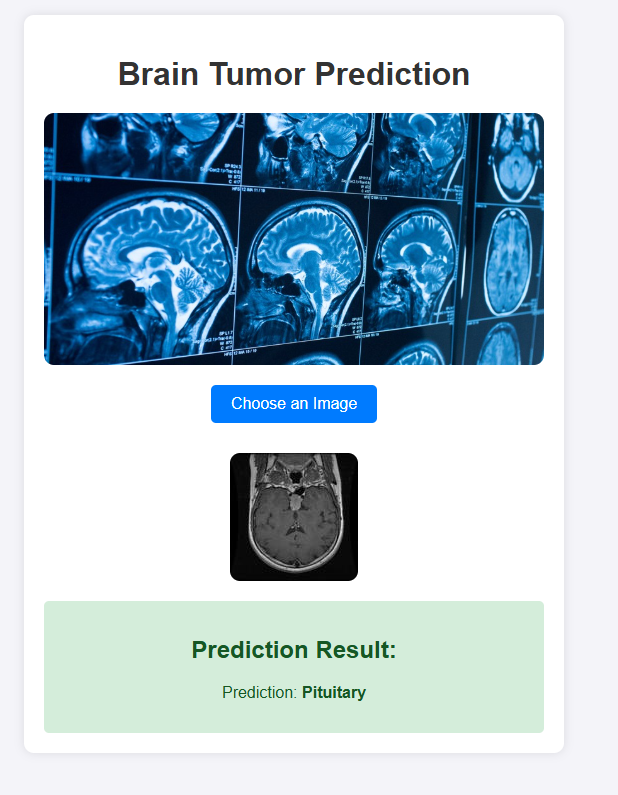